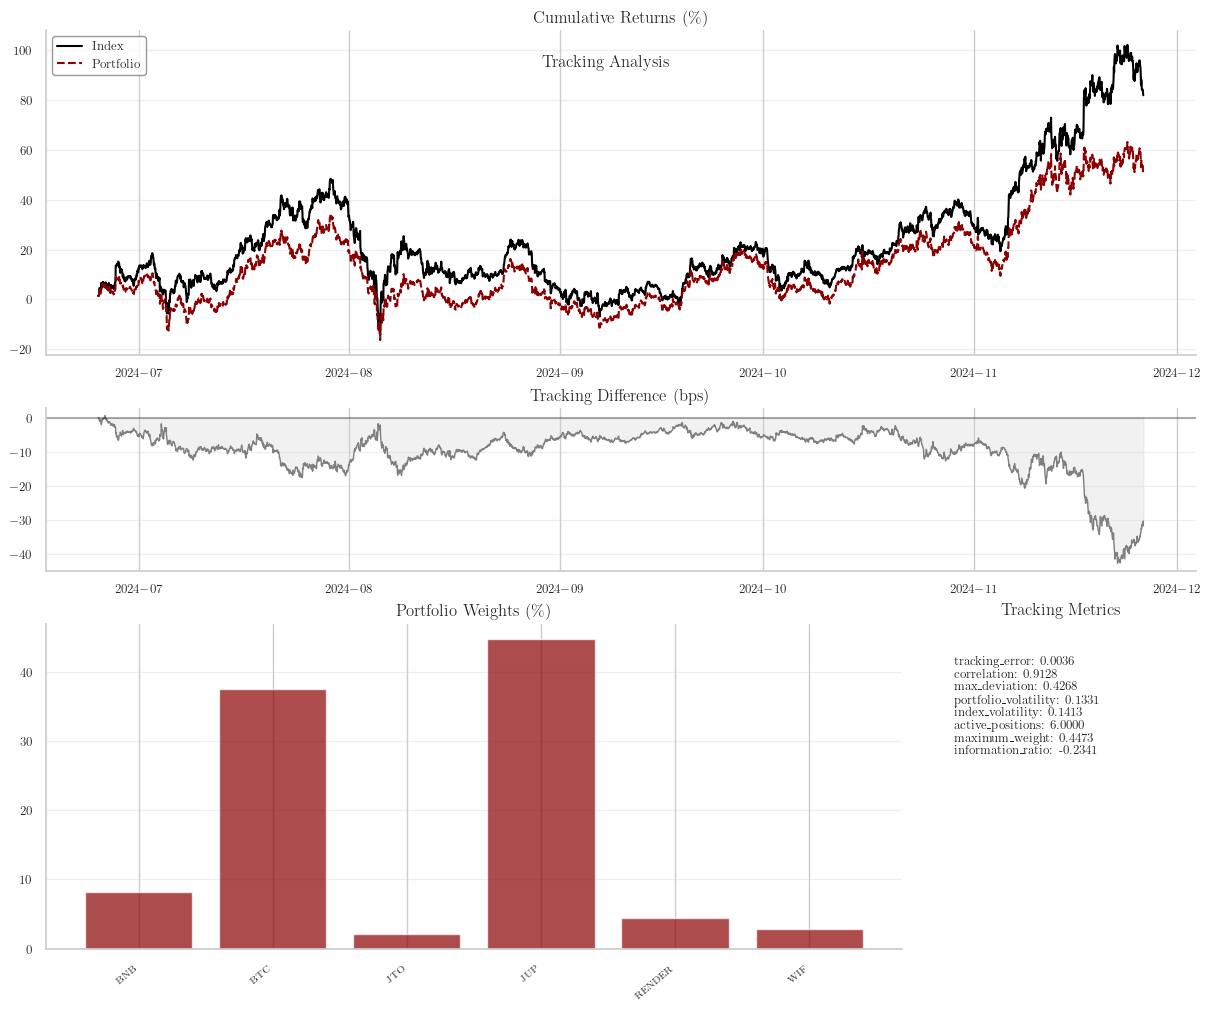

In [4]:
import polars as pl
from replicate.data.loading import DataLoader
from replicate.data.align import align

from replicate.optimizers.mm import MMOptimizer
from replicate.evaluation.metrics import TrackingMetrics
from replicate.evaluation.visualizer import TrackingVisualizer

time_col = 'timestamp'
optimizer = MMOptimizer(measure='dr')

loader = DataLoader()
target, constituents = loader.load_data(
    data_type=DataLoader.CRYPTO_RETURNS,
    target_symbol="SOL",
    start_date="2024-06-25",
    end_date="2024-11-25",
    max_null_pct=0.01  # Allow up to 1% nulls
)

X = constituents.drop(time_col).collect().to_numpy()
r = target.drop(time_col).collect().to_numpy().flatten() # we expect 1d array

dates = target.select(time_col).collect().to_numpy().flatten()
asset_names = [c for c in constituents.collect_schema().names() if c != time_col]

# Optimize weights

# thres sets the minimum weight for a symbol to be considered active
# max_iter sets the maximum number of iterations
# p_neg_exp sets the final negative exponent of p -- this controls the search for sparsity
# lambda sets the sparsity regularization (reg 1e-6 to 1e-8)

# this is a dumb naive way to do things, just getting started

result_dict = optimizer.optimize(X, r, lambda_=1e-7, u=0.5, p_neg_exp=8, thres=2e-2, max_iter=10000)
weights = result_dict['weights']

# Calculate metrics
metrics = TrackingMetrics.calculate_metrics(
    X @ weights,
    r,
    weights
)

# Visualize results
TrackingVisualizer.plot_tracking_analysis(
    dates,
    X @ weights,
    r,
    weights,
    asset_names,
    metrics=metrics
);

In [ ]:
from replicate.data.loading import DataLoader
from replicate.data.analysis import train_test_split_data, analyze_train_test_results
from replicate.optimizers.mm import MMOptimizer

# Initialize loader and optimizer
loader = DataLoader()
optimizer = MMOptimizer(measure='hete')

sym = 'XLM'

# Load and split data
data = train_test_split_data(
    loader=loader,
    data_type=DataLoader.CRYPTO_RETURNS,
    target_symbol=sym,
    train_pct=0.65,
    start_date="2024-06-25",
    end_date="2024-11-25",
    time_col='timestamp'
)

# Optimize on training data
result_dict = optimizer.optimize(
    data['train']['X'], 
    data['train']['r'], 
    lambda_=1e-6, 
    u=0.5, 
    p_neg_exp=8, 
    thres=3e-2,
    hub=0.5
)

train_metrics, test_metrics = analyze_train_test_results(
    train_data=data['train'],
    test_data=data['test'],
    weights=result_dict['weights'],
    asset_names=data['asset_names'],
    title_prefix=f"{sym} Tracking",
    plot_combined=True  # This will use the new combined visualization
)